# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(800)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.998319159765998


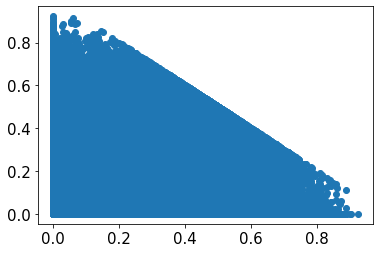

In [3]:
NumberofSources = 5
NumberofMixtures = 10
N = 5*1e5
S = 2*np.random.uniform(size = (NumberofSources,int(N)))-1
S = ProjectRowstoL1NormBall(S.T).T
S = S*(S>=0)

INPUT_STD = 0.5
A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)
SNR=30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

# Visualize Generated Sources and Mixtures

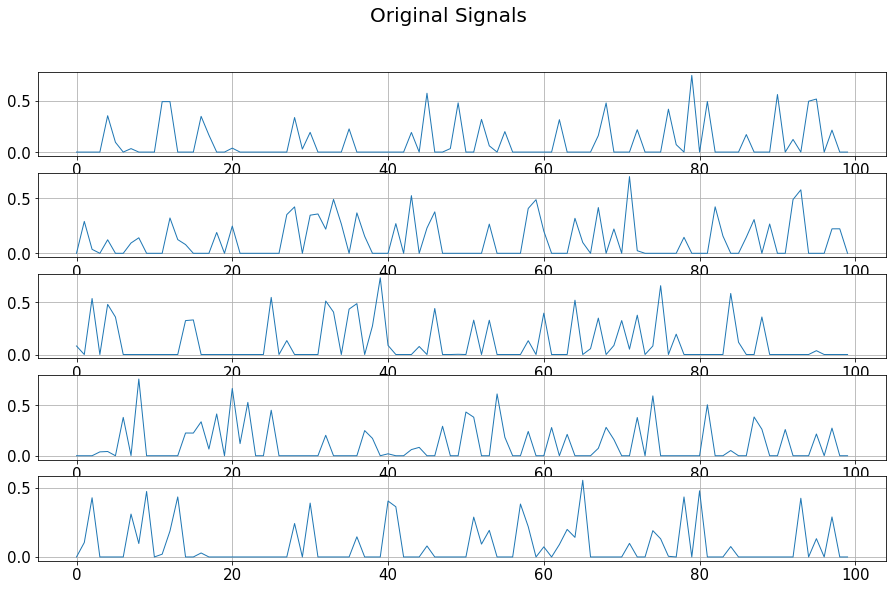

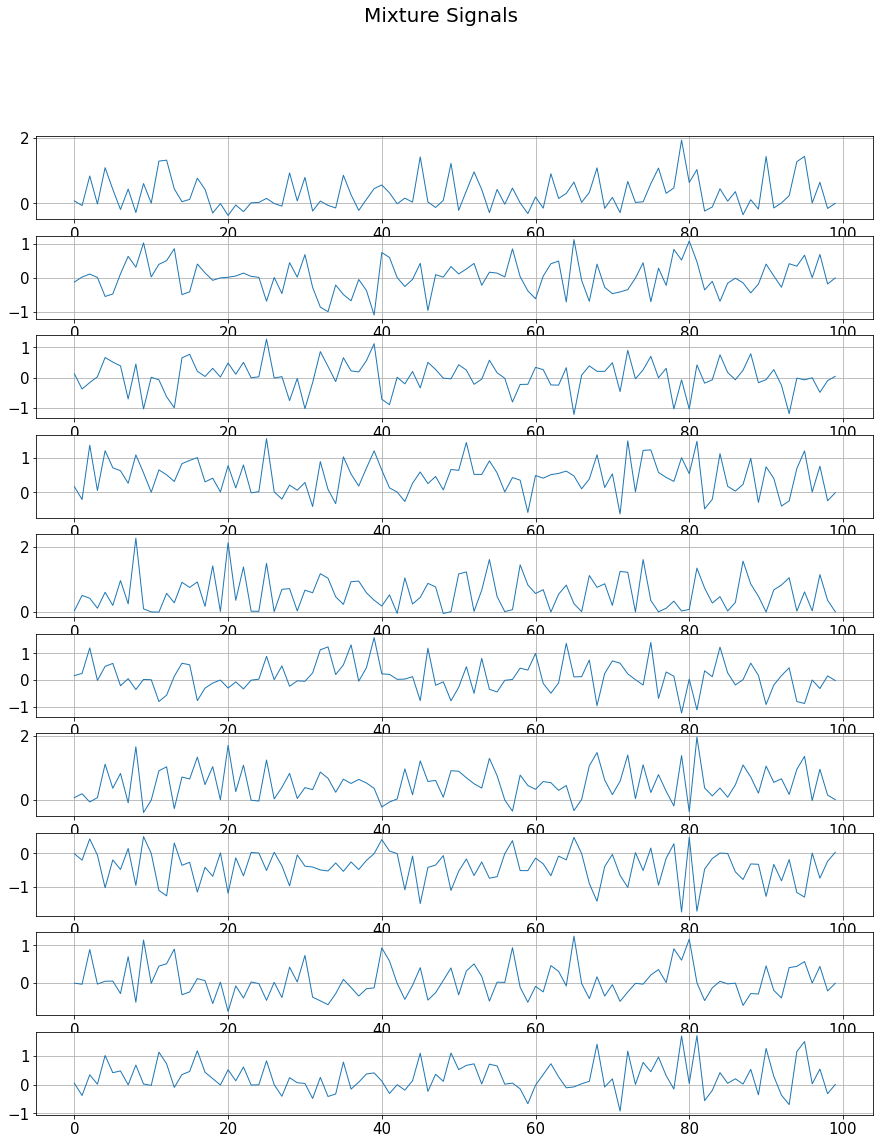

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [8,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

# Run WSM Algorithm on Mixture Signals

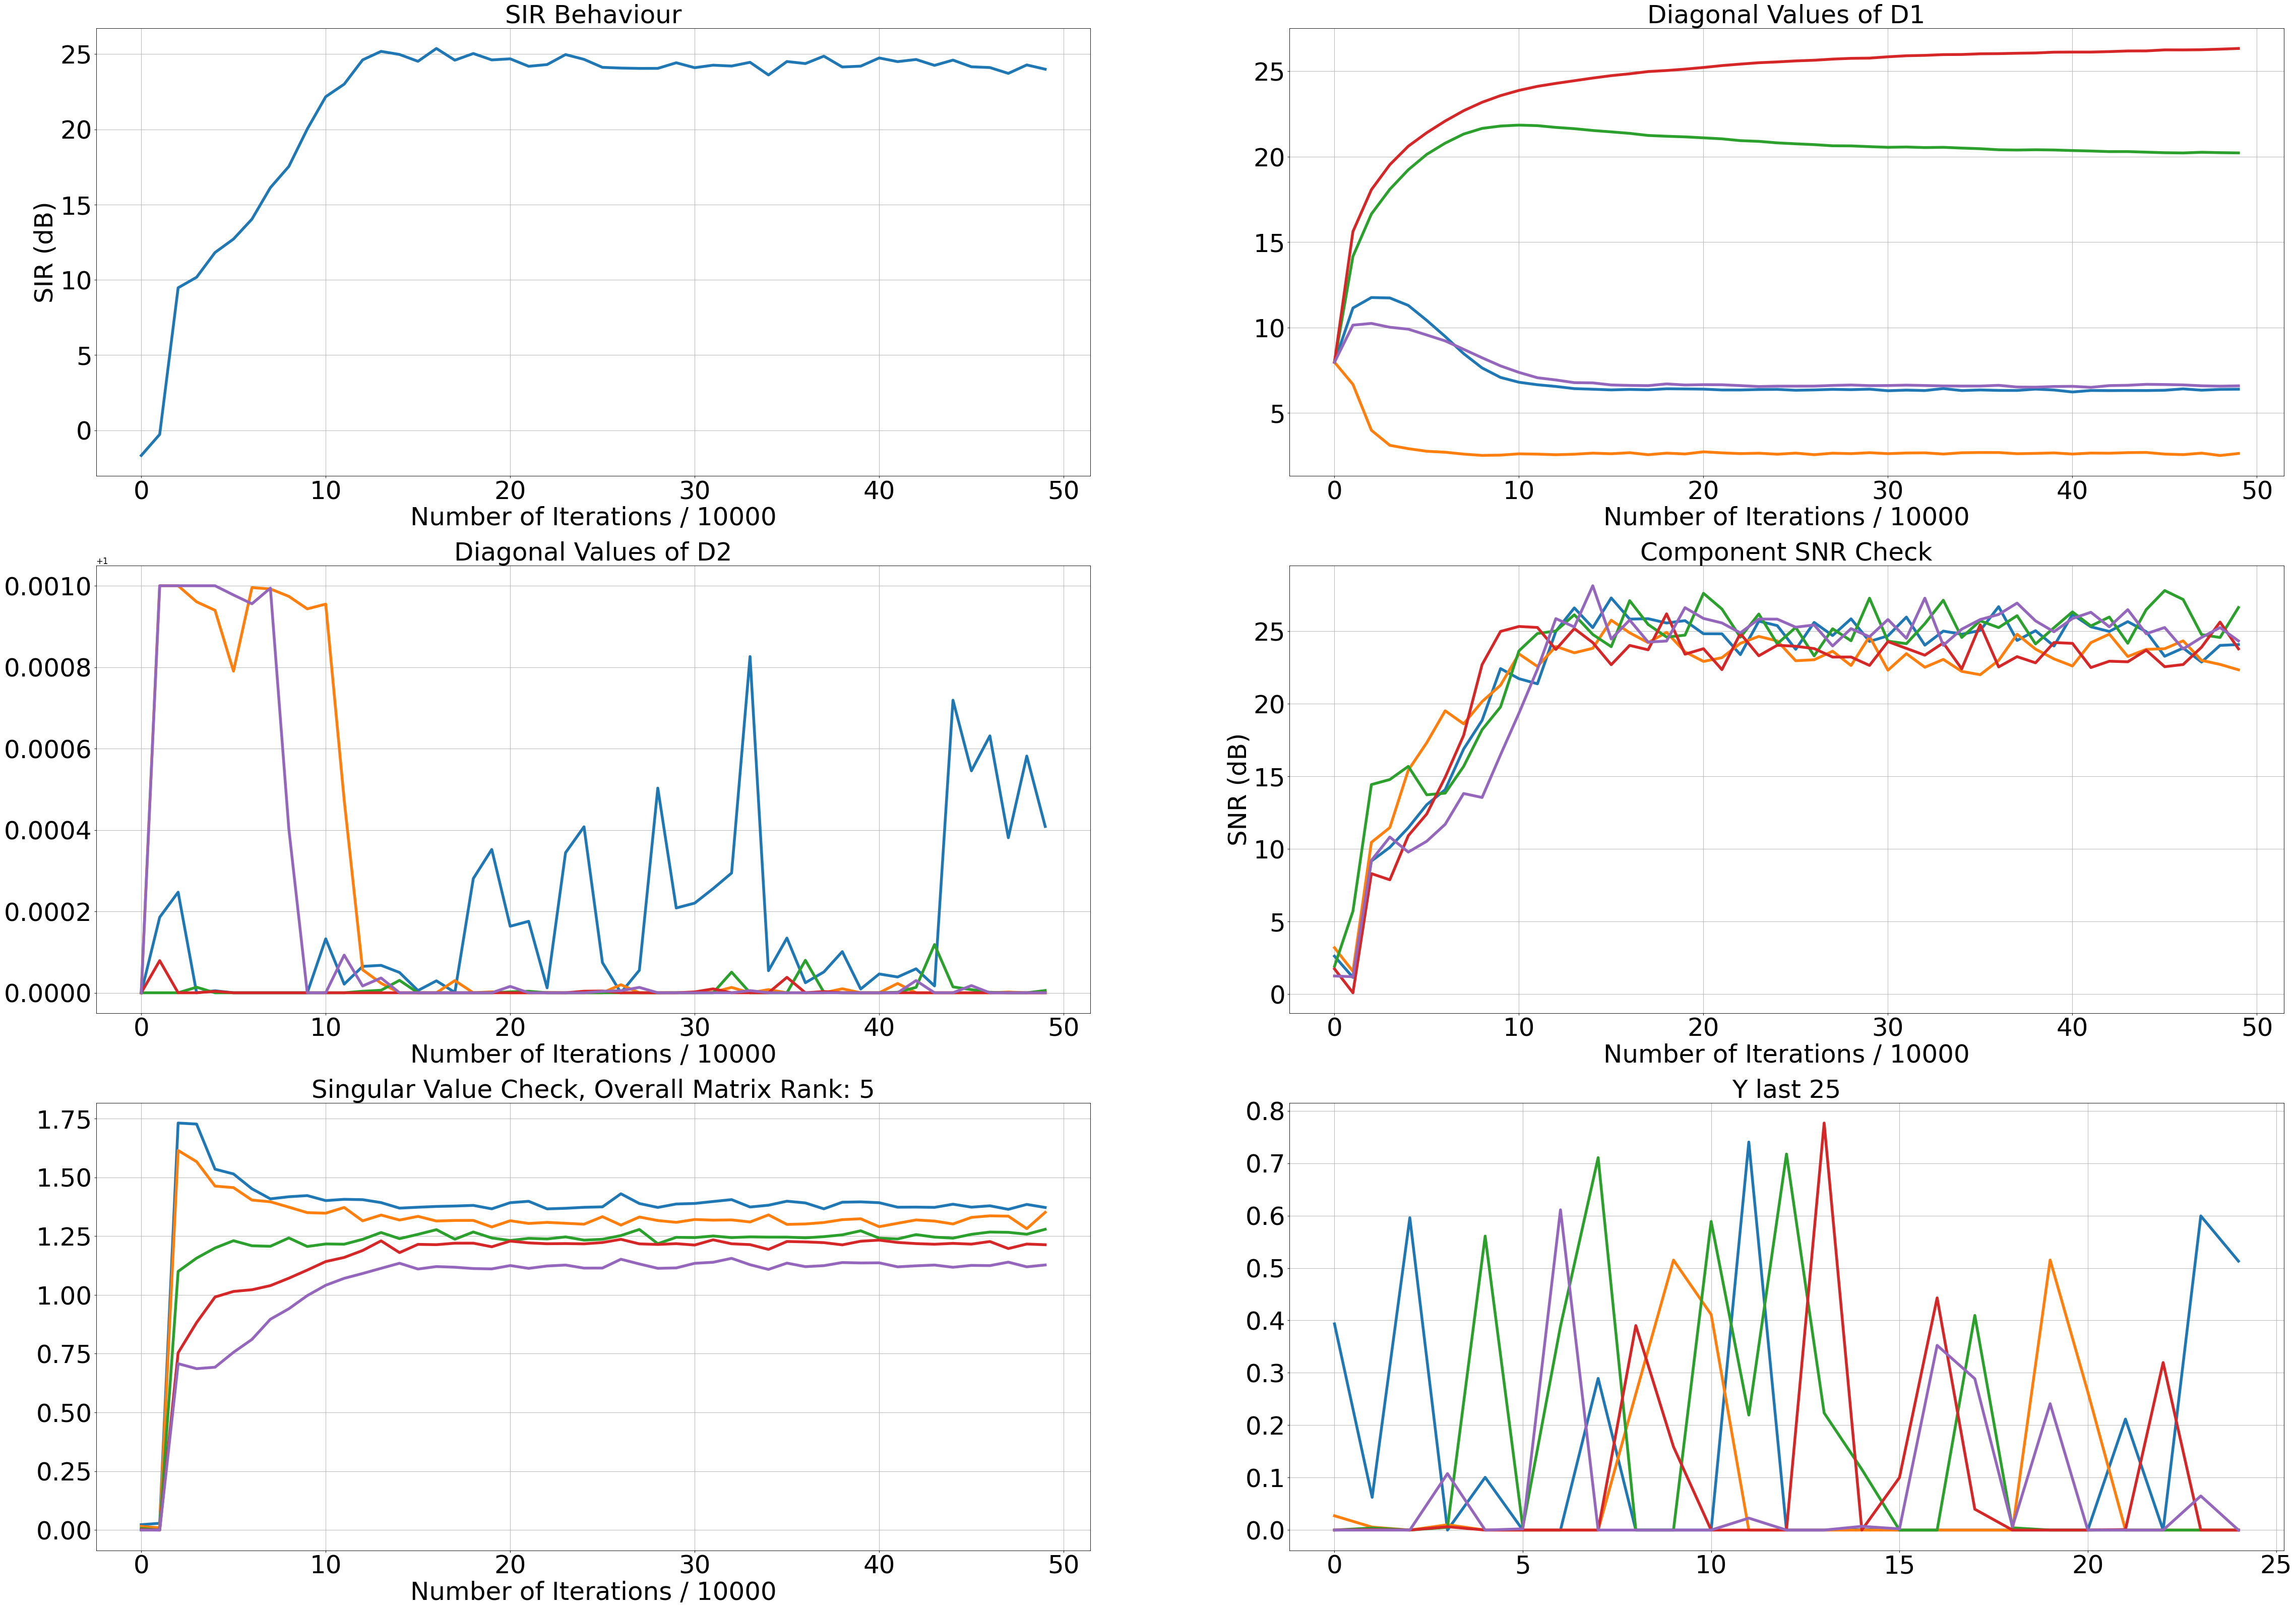

100%|██████████| 500000/500000 [08:36<00:00, 967.49it/s] 


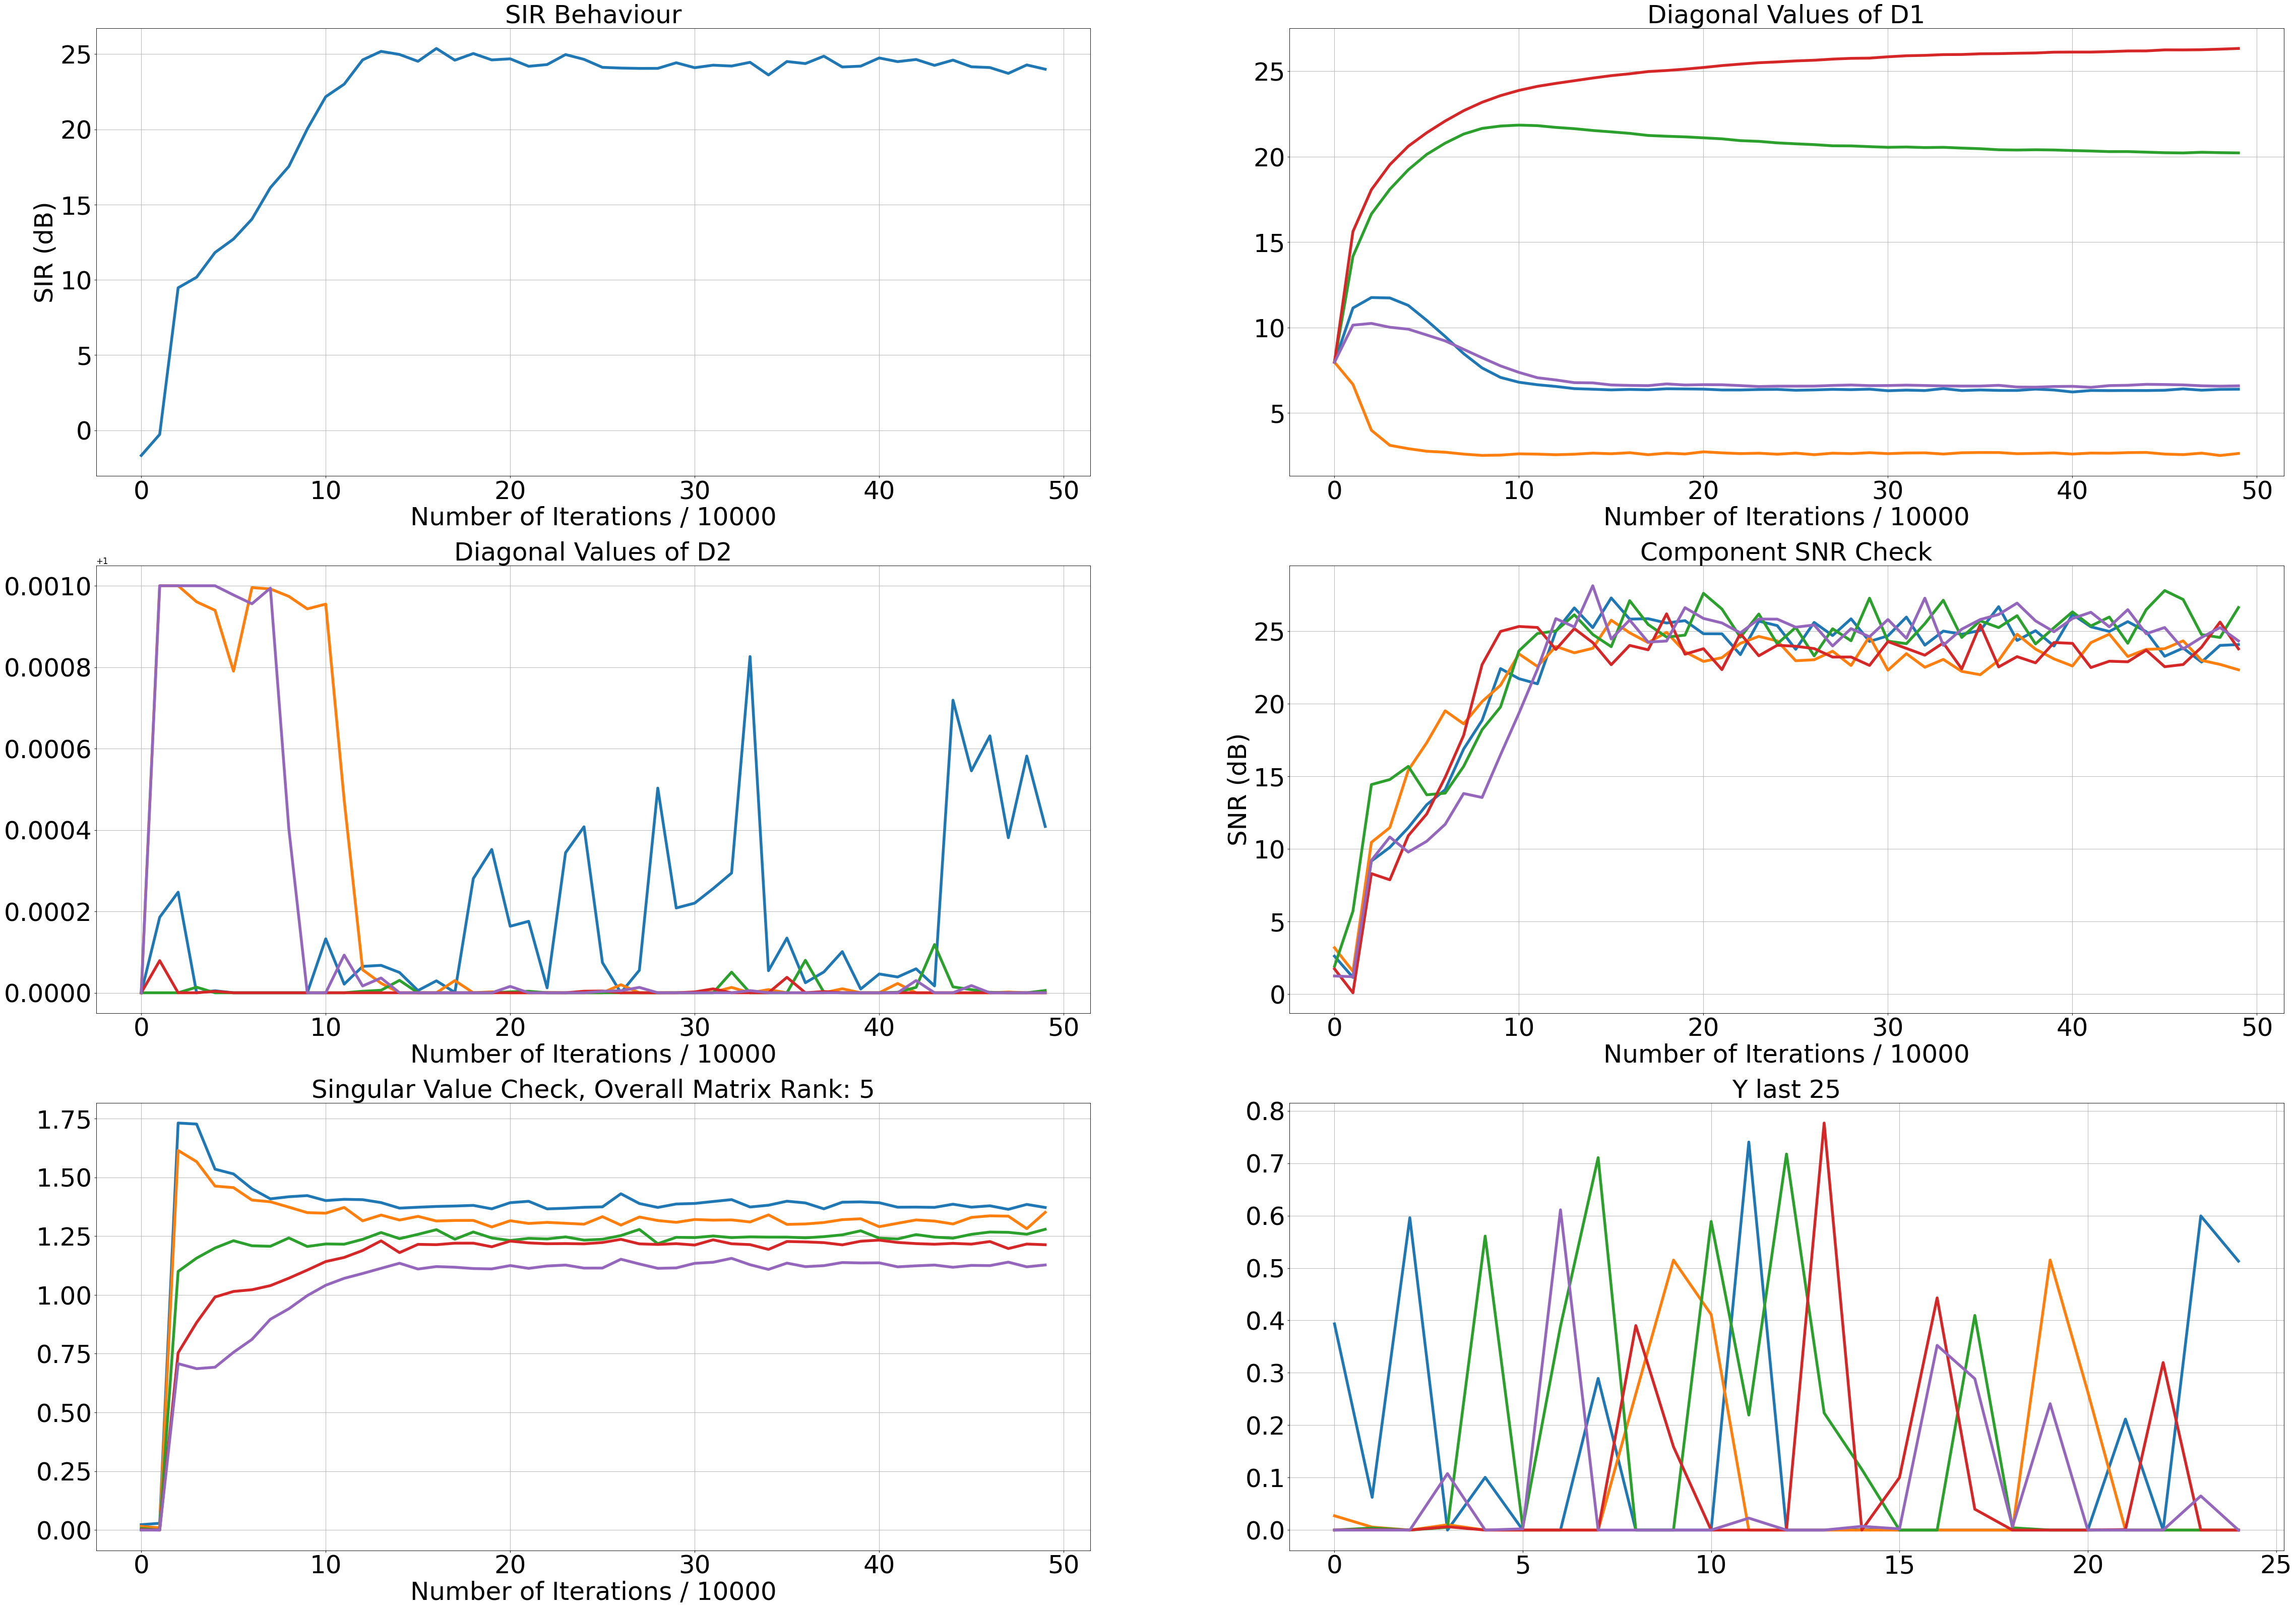

In [6]:
debug_iteration_point = 10000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

model.fit_batch_nnsparse(X, n_epochs = 1, neural_lr_start = 0.3, 
                       debug_iteration_point = debug_iteration_point, 
                       plot_in_jupyter = True)

# Visualize SNR Convergence of Each Source Component

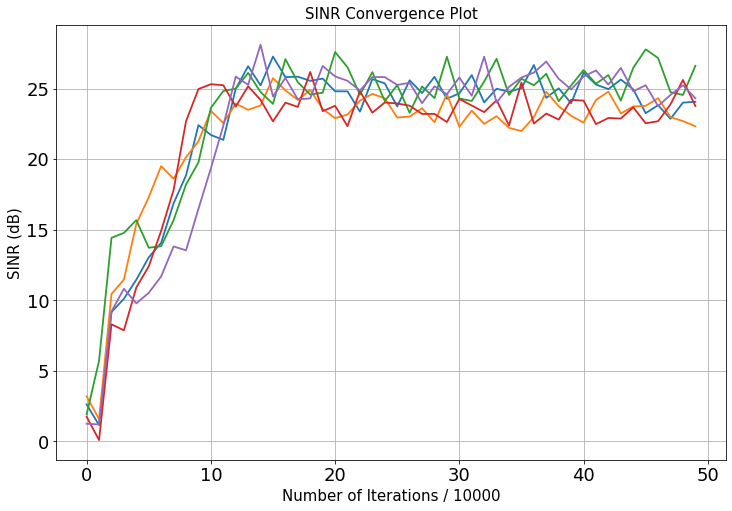

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean.T,Yzeromean.T)
coef_ = (Y_ * Szeromean.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(Szeromean.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, Szeromean)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [25.0468428  22.62585979 24.50626223 22.73783097 26.38701172]

Overall SINR : 24.018489960459668


# Vizualize Extracted Signals Compared to Original Sources

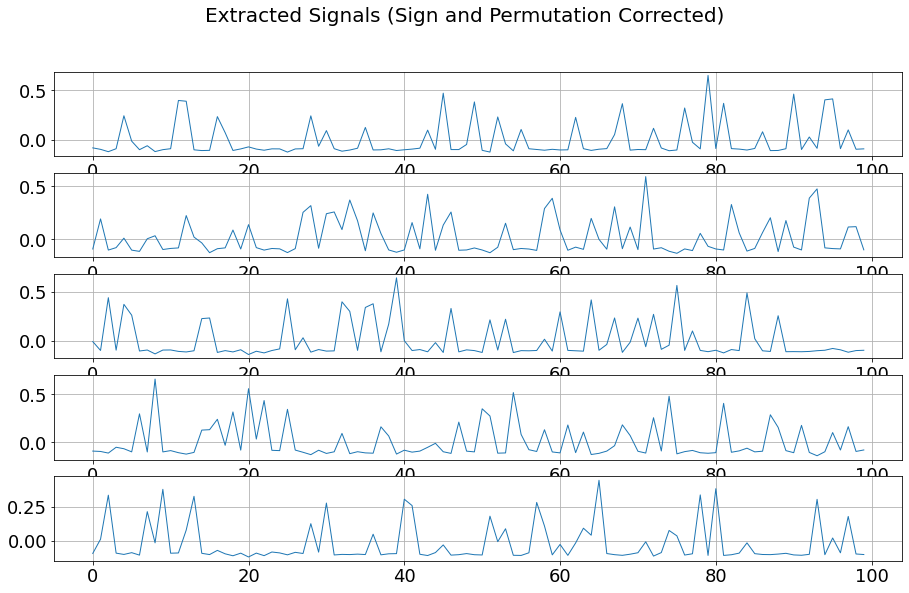

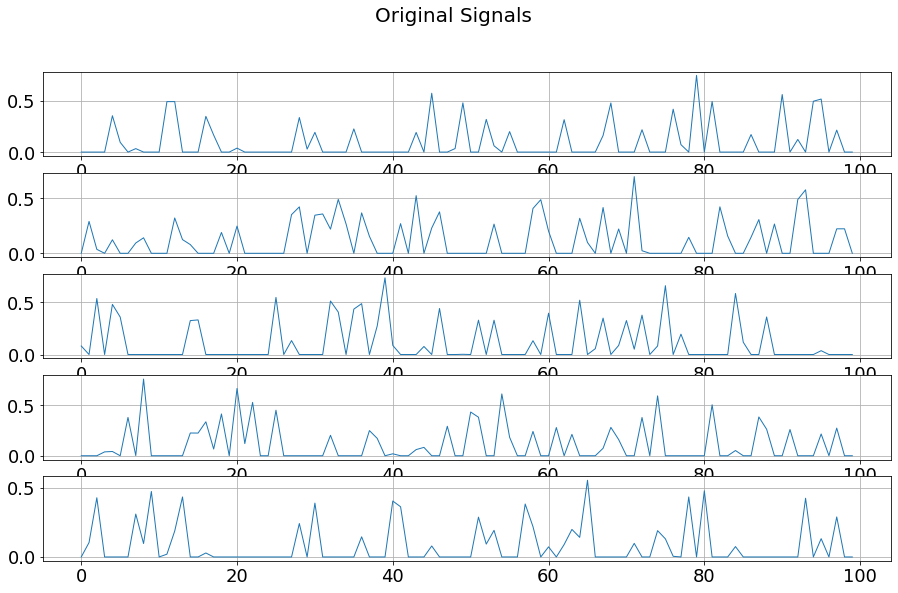

In [9]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [10]:
import mir_eval

In [11]:
S.shape, Y_.T.shape

((5, 500000), (5, 500000))

In [12]:
mir_eval.separation.bss_eval_sources(S, Y_.T,
                     compute_permutation=True)

(array([22.68639614, 21.19068238, 22.45787183, 21.24844958, 23.42869606]),
 array([23.95013162, 22.69823407, 23.63929637, 22.56893065, 24.74487612]),
 array([28.68168809, 26.54106647, 28.70773084, 27.08646668, 29.26940885]),
 array([0, 1, 2, 3, 4]))